In [1]:
# Import packages

import pandas as pd

import numpy as np
import _pickle as cpickle
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import sagemaker
import boto3
from sagemaker.predictor import csv_serializer
from sagemaker import get_execution_role
import sys
sys.path.insert(0, '/home/ec2-user/SageMaker/mymodule/')

from common_functions import psi
from common_functions import ks
from common_functions import gini 

from common_functions import gini_normalized

import boto3
import io
import os
import datetime as dt




%matplotlib inline

In [2]:
bucket = 'mf-ml-ds'

prefix = 'propensity_to_pay/source'
# s3_source = 's3://'+ bucket_name +'/propensity_to_fund/model_monitor/val_'
# s3_source_path  = s3_source + YYYYMM
# s3_score_target  = 'propensity_to_fund/model_monitor/val_' + YYYYMM +'/'
# # pps_score_file_name = 'xgb_weighted_score_pot_' + YYYYMM +'.csv'

# psi_file_path = 's3://'+ bucket_name + '/' + s3_score_target
model_path = 'propensity_to_pay/final_model/'


s3 = boto3.resource('s3')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [3]:
#change the most recent data for validation
df=pd.read_csv('s3://mf-ml-ds/propensity_to_pay/Production/slows.csv')

df.shape


(579619, 629)

In [4]:
ptable=pd.read_csv('../sagemaker/slows_capfloor.csv')

In [5]:
feature_location = 's3://{}/{}/{}'.format(bucket, prefix, 'feature')
df_feature = pd.read_csv(feature_location+'/feature.csv')
feature_names = df_feature.columns

In [6]:
feature_names

Index(['RefreshFicoScore', 'Original_Term', 'LNAPRO', 'number_of_prior_loans',
       'DISPOSABLE_INCOME', 'yrs_on_job_dbl', '__of_days_until_pmt_date',
       'MaxCarValue', 'Times29_Ever', 'Times30_Ever', 'Times90_Ever',
       'ADA_3236', 'ADA_3117', 'ADA_3113', 'ADA_3124', 'ADA_3756', 'ADA_3854',
       'ADA_3122', 'ADA_3135', 'ADA_3159', 'ADA_3268', 'ADA_3415', 'ADA_3743',
       'ADA_3755', 'ADA_3798', 'ADA_3805', 'ADA_3843', 'ADA_3206', 'ADA_3293',
       'ADA_3761', 'ADA_3835', 'ADA_3024', 'ADA_3027', 'ADA_3031', 'ADA_3580',
       'ADA_3723', 'ADA_3395', 'ADA_3724', 'ADA_3758', 'ADA_3166', 'Homeowner',
       'Auto_Pay_flag', 'PB', 'Coborrower', 'acflnps_n', 'lendingtree',
       'CreditKumar', 'upb_ratio'],
      dtype='object')

In [7]:
y_id=df.loc[:,'FFC_Source_Input_2']

In [8]:

X_val=df[feature_names]

In [9]:
    
    
    for col in X_val.columns:
        p1 = ptable[col].min()
        p99= ptable[col].max()
    
        X_val.loc[X_val[col] <= p1, col] = p1
        X_val.loc[X_val[col] >= p99, col] = p99
        
X_val=X_val.fillna(0)
    

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

ML Preparation

In [10]:
endpoint_name='mf-ml-pps-slows-xgb-jn-2022-02-14-19-56-07-434'



In [11]:
xgb_predictor = sagemaker.predictor.Predictor(endpoint_name = endpoint_name
                                       , sagemaker_session=sagemaker.Session()
                                       ,serializer=sagemaker.serializers.CSVSerializer())

In [12]:
def predict(data, model, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, model.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')



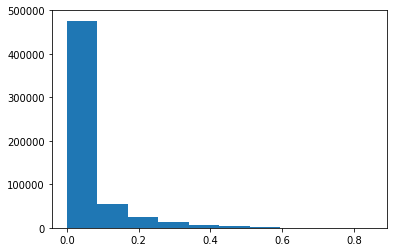

In [13]:
predictions = predict(X_val.to_numpy(), xgb_predictor)
plt.hist(predictions)
plt.show()


In [14]:
y_pred=np.round(predictions,4)
y_val_hat_df=pd.DataFrame(data=y_pred, columns=['pps'], index=X_val.index.copy())

df_pred=pd.merge(y_id, y_val_hat_df, how='left', left_index=True, right_index=True)

In [15]:
df_pred

,FFC_Source_Input_2,pps
0,7003025867,0.0219
1,3752004084,0.0008
2,7867007324,0.0009
3,7103009284,0.0730
4,7526003658,0.0770
...,...,...
579614,7901011540,0.0088
579615,4006019185,0.0468
579616,1516004269,0.0061
579617,5015003132,0.2511


In [16]:
df_pred.to_csv('slows_score.csv', index=False)
